<a href="https://colab.research.google.com/github/mustafaktaas/Python_StockPricePrediction_MachineLearning/blob/main/StockPricePrediction_GRU_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction with GRU

In [2]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

stockname = 'Tupras'
symbol = 'TUPRS.IS'

import yfinance as yf 
df = yf.download(symbol, start=start_date, end=end_date)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,4.250000,4.250000,4.250000,4.250000,1.889981,0
2010-01-04,4.250000,4.357142,4.214285,4.321428,1.921746,5387809
2010-01-05,4.464285,4.571428,4.428571,4.500000,2.001157,9854194
2010-01-06,4.500000,4.535714,4.428571,4.500000,2.001157,2408007
2010-01-07,4.464285,4.535714,4.428571,4.500000,2.001157,3059357


In [3]:
df = df.drop(df.tail(3).index)

In [4]:
df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-09,66.750000,67.400002,64.800003,65.199997,65.199997,22387077
2023-05-10,65.300003,66.449997,64.699997,65.000000,65.000000,19602729
2023-05-11,64.900002,71.500000,64.849998,71.500000,71.500000,54579075
2023-05-12,71.750000,75.199997,69.699997,71.000000,71.000000,44790062
2023-05-15,65.000000,69.050003,63.900002,64.199997,64.199997,34856015


In [5]:
pd.options.display.float_format = '{:.3f}'.format

In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,4.250,4.250,4.250,4.250,1.890,0
2010-01-04,4.250,4.357,4.214,4.321,1.922,5387809
2010-01-05,4.464,4.571,4.429,4.500,2.001,9854194
2010-01-06,4.500,4.536,4.429,4.500,2.001,2408007
2010-01-07,4.464,4.536,4.429,4.500,2.001,3059357


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3450 entries, 2010-01-01 to 2023-05-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3450 non-null   float64
 1   High       3450 non-null   float64
 2   Low        3450 non-null   float64
 3   Close      3450 non-null   float64
 4   Adj Close  3450 non-null   float64
 5   Volume     3450 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 188.7 KB


In [8]:
df.shape

(3450, 6)

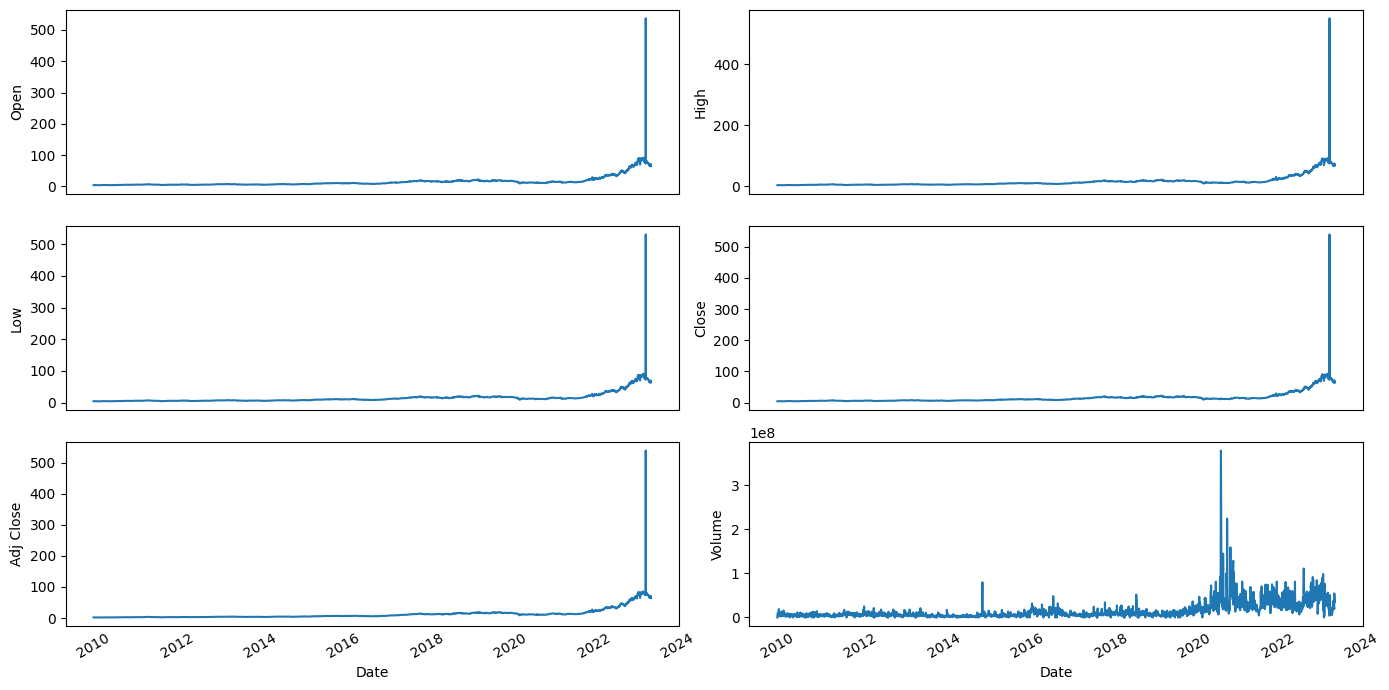

In [9]:
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [10]:
train_df = df.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            ,# 'Month' , 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-05-09,67.400,64.800,66.750,65.200,22387077,65.200
2023-05-10,66.450,64.700,65.300,65.000,19602729,65.000
2023-05-11,71.500,64.850,64.900,71.500,54579075,71.500
2023-05-12,75.200,69.700,71.750,71.000,44790062,71.000
2023-05-15,69.050,63.900,65.000,64.200,34856015,64.200


In [11]:
data_filtered.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2023-05-09,67.400,64.800,66.750,65.200,22387077
2023-05-10,66.450,64.700,65.300,65.000,19602729
2023-05-11,71.500,64.850,64.900,71.500,54579075
2023-05-12,75.200,69.700,71.750,71.000,44790062
2023-05-15,69.050,63.900,65.000,64.200,34856015


#### Burada girdi verilerini numpy formatına dönüştürüp 0-1 arasında MinMaxScaler ile ölçeklendiriyoruz.Bu ölçeklendirdiğimiz veriler eğitildiğinde sonuçlar da ölçeklenmiş şekilde gelecektir bunu geri dönüştürmeyi unutmamalıyız.

In [12]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3450, 5)


In [13]:
np.set_printoptions(precision=3)

np_data = np.around(np_data, 3)

In [14]:
np_data[1]

array([4.357e+00, 4.214e+00, 4.250e+00, 4.321e+00, 5.388e+06])

In [15]:
np_data_scaled[0]

array([0.   , 0.001, 0.001, 0.001, 0.   ])

In [16]:
np_Close_scaled[0]

array([0.001])

In [17]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2710, 50, 5) (2710,)
(690, 50, 5) (690,)
0.0009343923111671745
0.0009343923111671745


## Gated Recurrent Units(GRU)

Basit bir ifadeyle, GRU biriminin, LSTM birimi gibi bilgi akışını kontrol etmek için bir bellek birimi kullanması gerekmez. Herhangi bir kontrol olmaksızın tüm gizli durumları doğrudan kullanabilir. GRU'lar daha az parametreye sahiptir ve bu nedenle biraz daha hızlı çalışabilir veya genelleme yapmak için daha az veriye ihtiyaç duyabilir. Ancak, büyük verilerle, daha yüksek anlamlılığa sahip LSTM'ler daha iyi sonuçlara yol açabilir.

İki kapısı olması dışında LSTM'lere neredeyse benzerler: sıfırlama kapısı ve güncelleme kapısı. Sıfırlama kapısı, yeni girdinin önceki belleğe nasıl birleştirileceğini belirler ve güncelleme kapısı, önceki durumun ne kadarının tutulacağını belirler. GRU'daki güncelleme kapısı, LSTM'deki giriş kapısı ve unutma kapısıdır. Çıktıyı hesaplamadan önce GRU'da ikinci doğrusal olmama durumumuz yok, onların da çıkış kapısı yok.

In [18]:
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

250 50 5


In [19]:
model = Sequential()

model.add(GRU(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(GRU(n_neurons, return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [20]:
callbacks = EarlyStopping(monitor = "loss",patience = 8,verbose = 1)

In [21]:
epochs = 50
batch_size = 16
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
170/170 [==============================] - 44s 227ms/step - loss: 4.3544e-05 - val_loss: 0.0013
Epoch 2/50
170/170 [==============================] - 37s 220ms/step - loss: 4.4929e-07 - val_loss: 0.0013
Epoch 3/50
170/170 [==============================] - 39s 232ms/step - loss: 4.9665e-07 - val_loss: 0.0013
Epoch 4/50
170/170 [==============================] - 39s 228ms/step - loss: 4.8802e-07 - val_loss: 0.0013
Epoch 5/50
170/170 [==============================] - 39s 230ms/step - loss: 5.1263e-07 - val_loss: 0.0013
Epoch 6/50
170/170 [==============================] - 39s 229ms/step - loss: 6.1754e-07 - val_loss: 0.0014
Epoch 7/50
170/170 [==============================] - 40s 234ms/step - loss: 5.3720e-07 - val_loss: 0.0014
Epoch 8/50
170/170 [==============================] - 39s 230ms/step - loss: 6.1160e-07 - val_loss: 0.0014
Epoch 9/50
170/170 [==============================] - 38s 226ms/step - loss: 7.0094e-07 - val_loss: 0.0014
Epoch 10/50
170/170 [================

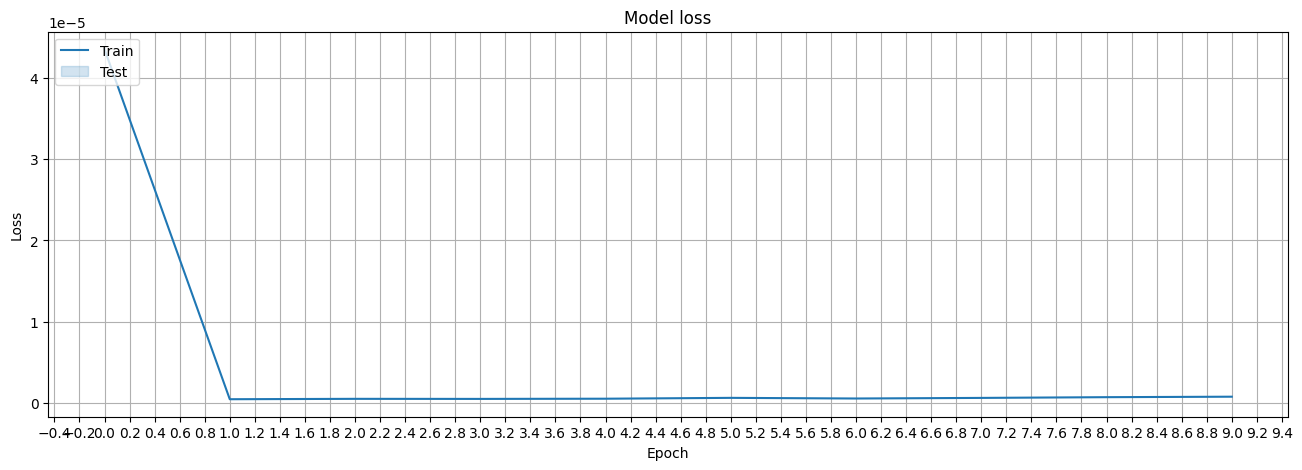

In [22]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [23]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 2s 73ms/step
R2: 0.543
Median Absolute Error (MAE): 2.51
Mean Absolute Percentage Error (MAPE): 4.46 %
Median Absolute Percentage Error (MDAPE): 2.85 %


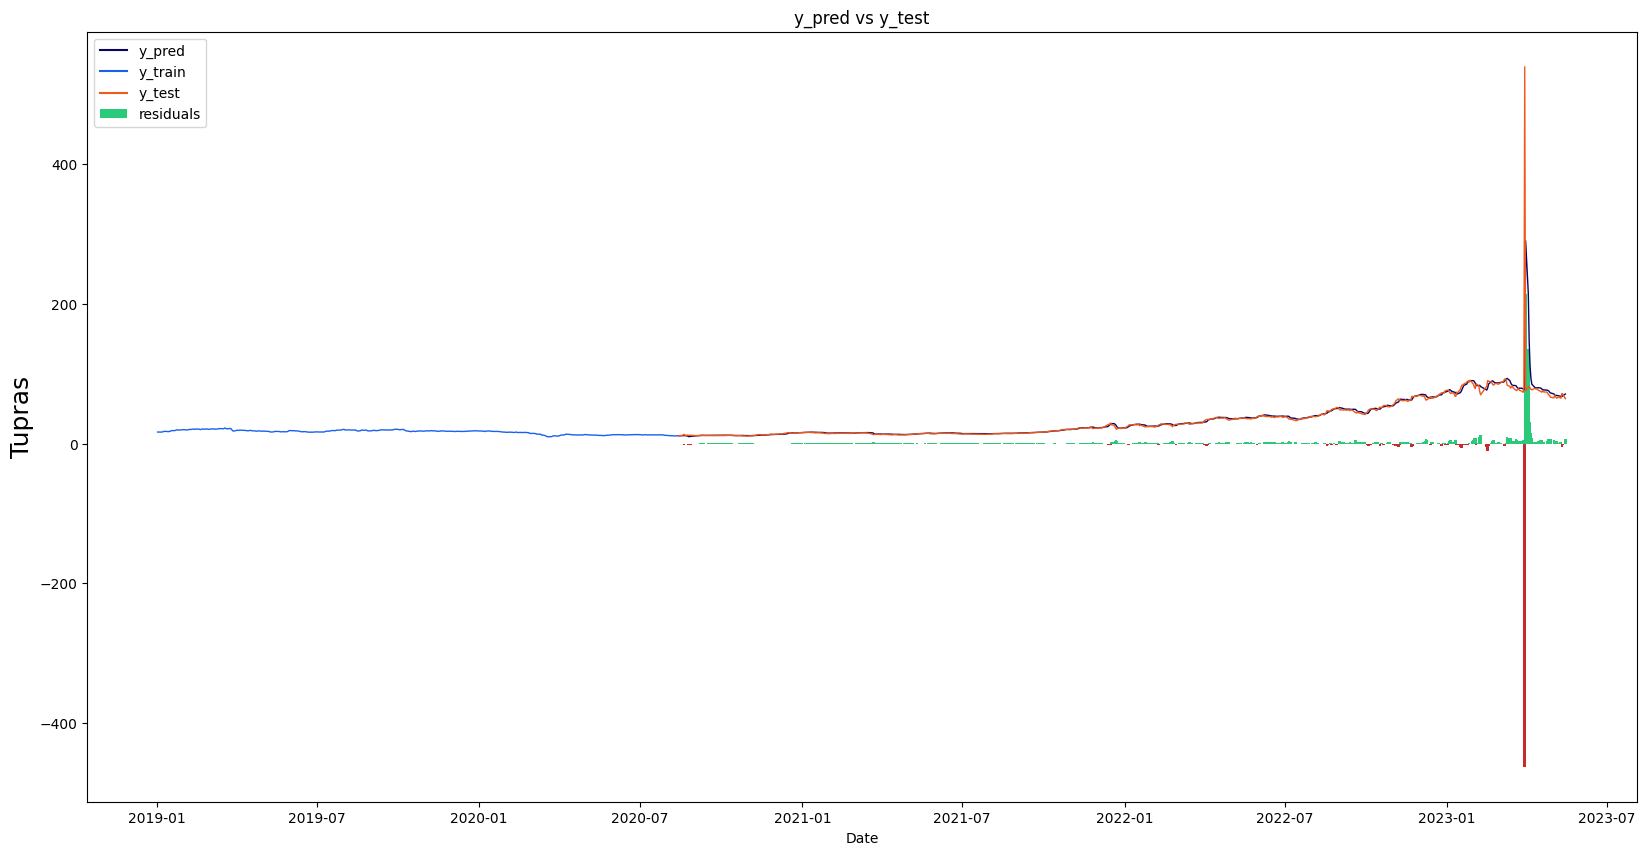

In [24]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(20, 10))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [25]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 32ms/step
The close price for Tupras at 2023-05-19 was 64.2
The predicted close price is 69.29000091552734 (+7.35%)


## WindowSize + BatchSize Update

In [26]:
sequence_length = 64

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2696, 64, 5) (2696,)
(690, 64, 5) (690,)
0.0022024948890284144
0.0022024948890284144


In [27]:
train_data.shape

(2760, 5)

In [28]:
model=Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(GRU(n_neurons,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(GRU(n_neurons,return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

320 64 5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 64, 320)           313920    
                                                                 
 gru_3 (GRU)                 (None, 320)               616320    
                                                                 
 dense_2 (Dense)             (None, 5)                 1605      
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 931,851
Trainable params: 931,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
callbacks = EarlyStopping(monitor = "loss",patience = 8,verbose = 1)

In [30]:
epochs = 50
batch_size = 32
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
85/85 [==============================] - 51s 553ms/step - loss: 1.5835e-04 - val_loss: 0.0013
Epoch 2/50
85/85 [==============================] - 48s 565ms/step - loss: 4.4364e-07 - val_loss: 0.0013
Epoch 3/50
85/85 [==============================] - 50s 589ms/step - loss: 4.9348e-07 - val_loss: 0.0013
Epoch 4/50
85/85 [==============================] - 45s 535ms/step - loss: 4.5924e-07 - val_loss: 0.0013
Epoch 5/50
85/85 [==============================] - 47s 550ms/step - loss: 4.4357e-07 - val_loss: 0.0013
Epoch 6/50
85/85 [==============================] - 46s 545ms/step - loss: 4.3972e-07 - val_loss: 0.0013
Epoch 7/50
85/85 [==============================] - 44s 518ms/step - loss: 4.7875e-07 - val_loss: 0.0013
Epoch 8/50
85/85 [==============================] - 45s 531ms/step - loss: 4.1623e-07 - val_loss: 0.0013
Epoch 9/50
85/85 [==============================] - 44s 523ms/step - loss: 4.3567e-07 - val_loss: 0.0013
Epoch 10/50
85/85 [==============================] - 47

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

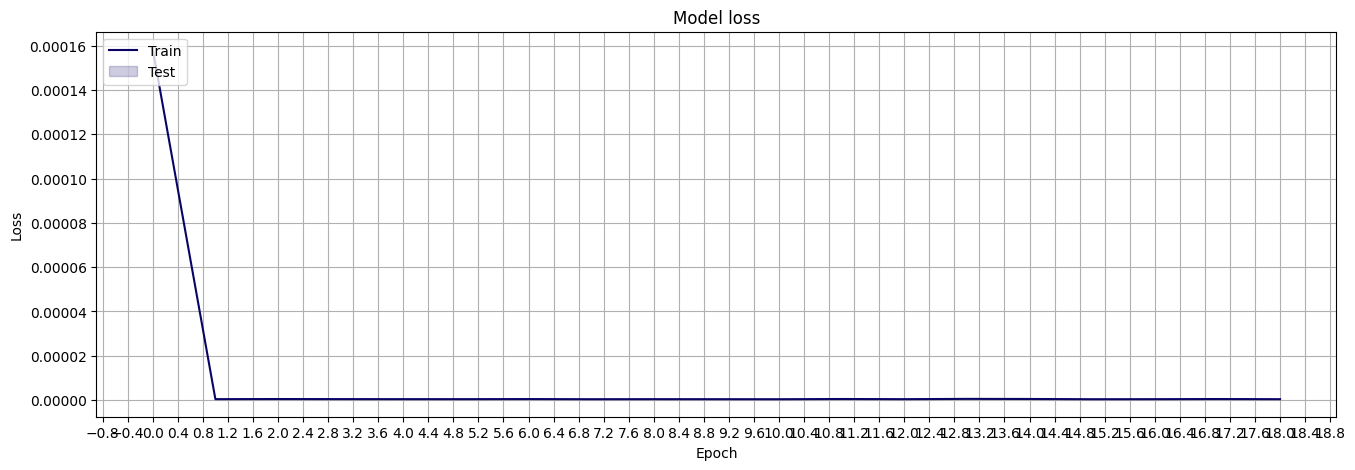

In [31]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [32]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 4s 145ms/step
R2: 0.548
Median Absolute Error (MAE): 2.35
Mean Absolute Percentage Error (MAPE): 3.68 %
Median Absolute Percentage Error (MDAPE): 1.97 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

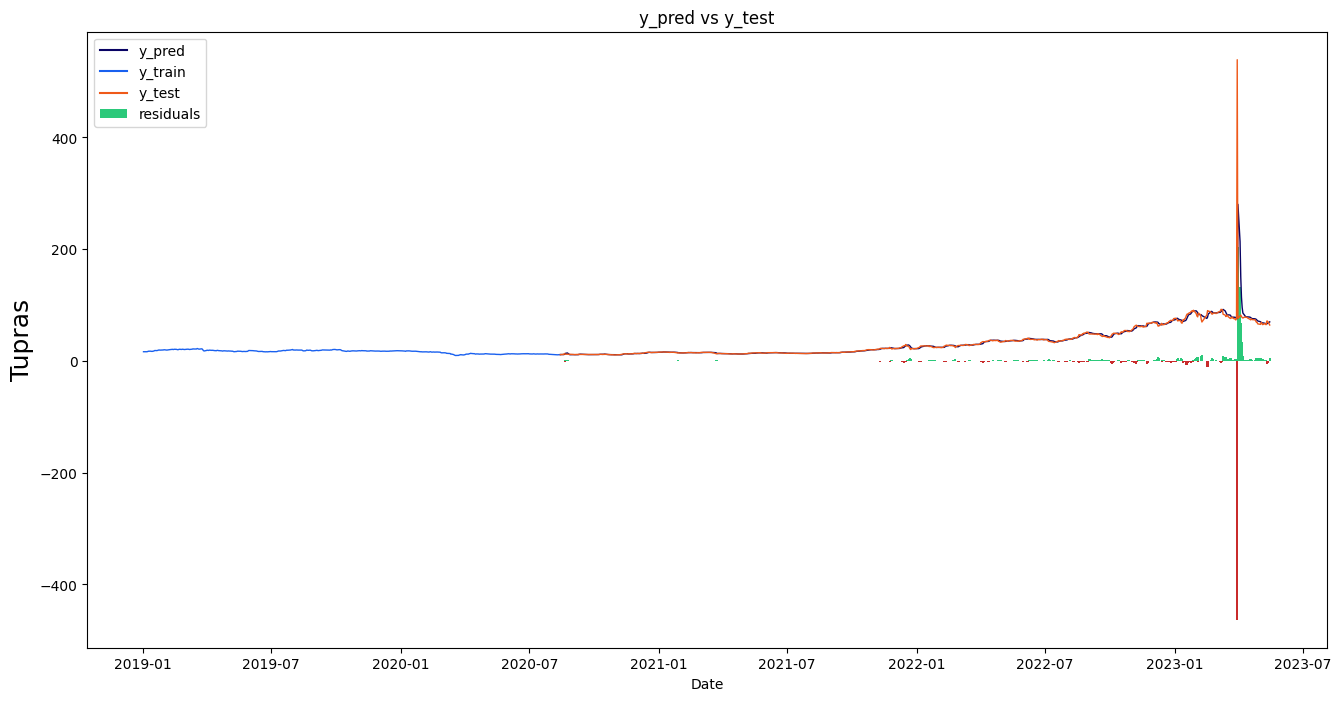

In [33]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [34]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 40ms/step
The close price for Tupras at 2023-05-19 was 64.2
The predicted close price is 68.51000213623047 (+6.29%)


## Hidden Layer + Neuron

In [35]:
sequence_length = 64

index_Close = data.columns.get_loc("Close")

# Verileri train test olarak ayırın.
# Verilerin %80 ini eğitim için kullanacağız.
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# Model için verileri bu biçime dönüştürün : [samples, time steps, features] 
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    # Sonra bunları numpy array'e dönüştür.    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# İkinci girdi örneğinin son kapanış fiyatı ilk tahmin değerine eşit olmalıdır.
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2696, 64, 5) (2696,)
(690, 64, 5) (690,)
0.0022024948890284144
0.0022024948890284144


In [36]:
train_data.shape

(2760, 5)

In [37]:
model=Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(GRU(n_neurons,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(GRU(160,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(GRU(80,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(GRU(40,return_sequences=False))

model.add(Dense(5))

model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

320 64 5
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64, 320)           313920    
                                                                 
 gru_5 (GRU)                 (None, 64, 160)           231360    
                                                                 
 gru_6 (GRU)                 (None, 64, 80)            58080     
                                                                 
 gru_7 (GRU)                 (None, 40)                14640     
                                                                 
 dense_4 (Dense)             (None, 5)                 205       
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 618,211
Trainable params: 618,2

In [38]:
callbacks = EarlyStopping(monitor = "loss",patience = 8,verbose = 1)

In [39]:
epochs = 50
batch_size = 32
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [callbacks]                 
                   )
    

Epoch 1/50
85/85 [==============================] - 48s 462ms/step - loss: 1.7289e-04 - val_loss: 0.0012
Epoch 2/50
85/85 [==============================] - 37s 440ms/step - loss: 9.4130e-07 - val_loss: 0.0012
Epoch 3/50
85/85 [==============================] - 39s 458ms/step - loss: 9.3028e-07 - val_loss: 0.0012
Epoch 4/50
85/85 [==============================] - 38s 450ms/step - loss: 1.0256e-06 - val_loss: 0.0012
Epoch 5/50
85/85 [==============================] - 38s 449ms/step - loss: 8.4403e-07 - val_loss: 0.0012
Epoch 6/50
85/85 [==============================] - 38s 447ms/step - loss: 9.1887e-07 - val_loss: 0.0012
Epoch 7/50
85/85 [==============================] - 38s 449ms/step - loss: 8.4400e-07 - val_loss: 0.0012
Epoch 8/50
85/85 [==============================] - 38s 451ms/step - loss: 8.7594e-07 - val_loss: 0.0012
Epoch 9/50
85/85 [==============================] - 38s 447ms/step - loss: 8.1685e-07 - val_loss: 0.0012
Epoch 10/50
85/85 [==============================] - 39

#### Burada tahmin başarı anlamında bir kayıp eğrisi çizdiriyoruz.

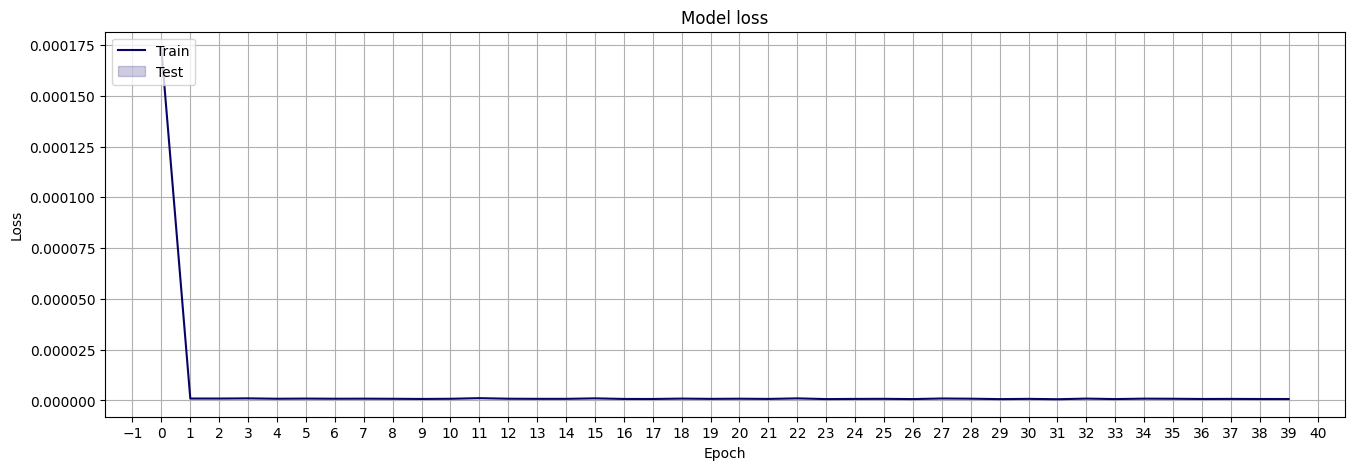

In [40]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

#### Sinir ağı regresyon modelini eğittikten sonra performansını ölçmek istiyoruz. Önce tahminlerin ölçeklemesini tersine çevirmeliyiz. Daha sonra MAE, MAPE ve MDAPE gibi farklı hata metriklerini hesaplıyoruz. Ardından, bir çizgi grafiğindeki tahminleri gerçek değerlerle karşılaştıracağız.

In [41]:
y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

R2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(R2, 3)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 4s 118ms/step
R2: 0.569
Median Absolute Error (MAE): 2.48
Mean Absolute Percentage Error (MAPE): 4.02 %
Median Absolute Percentage Error (MDAPE): 2.2 %


#### Çizgi grafiği, tahminin gerçek değerlere yakın olduğunu ancak kısmen ondan saptığını gösterir. Gerçek değerler ve tahminler arasındaki sapmalara artıklar denir. Bizim modumuz için, bunlar en çok artan piyasa oynaklığının olduğu dönemlerde ve en az da istikrarlı piyasa hareketinin olduğu dönemlerde önemli görünmektedir, bu mantıklıdır çünkü ani hareketlerin genellikle tahmin edilmesi daha zordur.

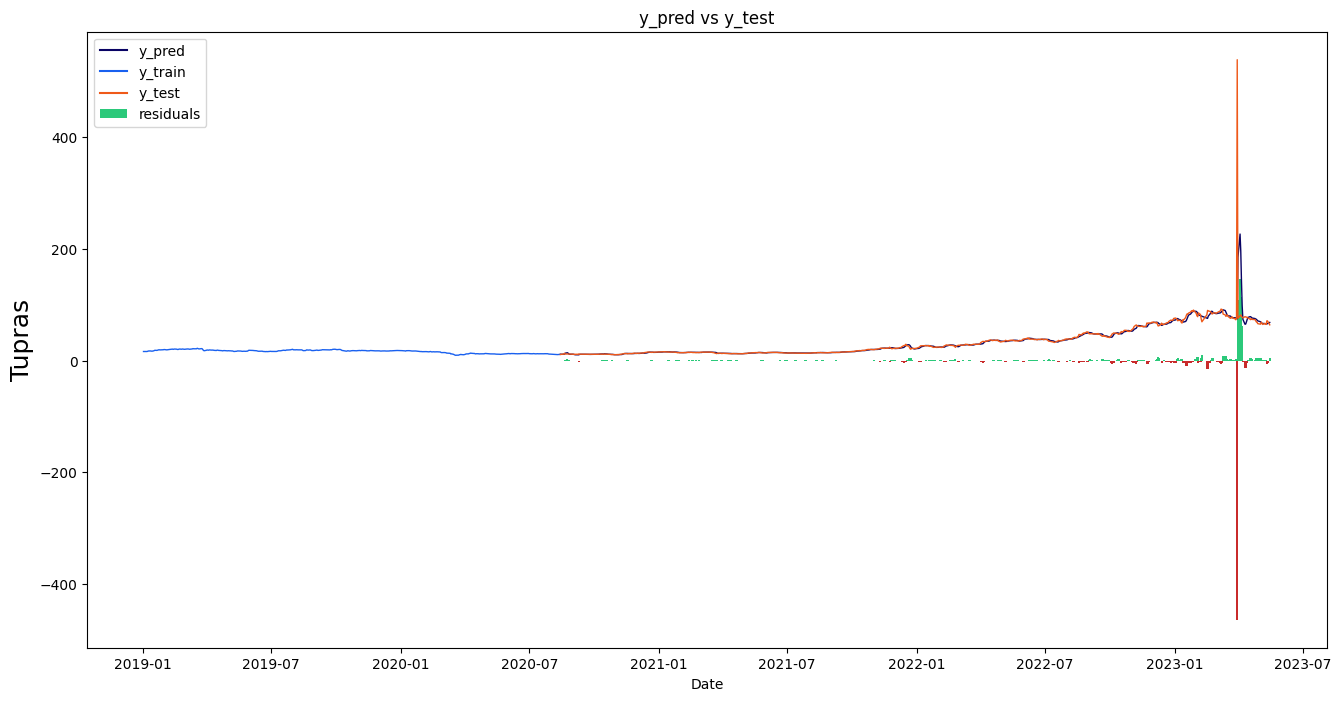

In [42]:
# Tarihin görüntülendiği tarih
display_start_date = "2019-01-01" 

# Geçerli ve tahmini fiyatlar arasındaki fark
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Daha yakın bir zaman dilimine yakınlaştırın
df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Farkların grafiği
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [43]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Son N günlük kapanış fiyatı değerlerini alın ve verileri 0 ile 1 arasında değerler olacak şekilde ölçeklendirin
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Boş bir liste oluşturun ve son N günü ekleyin
X_test_new = []
X_test_new.append(last_N_days_scaled)

# X_test veri kümesini numpy dizisine dönüştürün ve verileri tekrar eski haline çevirin
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Bir sonraki gün için son fiyatı ve tahmini fiyatı yazdırın
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 44ms/step
The close price for Tupras at 2023-05-19 was 64.2
The predicted close price is 68.69000244140625 (+6.54%)
